# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite
!pip install nltk
!pip install sklearn
!pip install matplotlib
!pip install numpy


In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


# Modifying the preprocessing function for POS tagging (Task 4)

In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    # a postagger for use in exercises
    tmp_words = [] # creating a list for storing the words in the "example" list of tuples
    for word, label in example:
        tmp_words.append(word) # appending each word in the sentence to the list
    
    # setting up a POS tagger
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    pos_list = posttagger.tag(tmp_words) # list of tuples of words and pos tags
    list1 = [] # creating a list which stores entries of the form word@postag
    for word, label in pos_list:
        list1.append(word + "@" + label) # appending each word@postag entry
    
    
    list2= [] # list for storing the bio tags
    for word, label in example:
        list2.append(label) # appends the bio tags to the list
        
    list3 = list(zip(list1, list2)) # making a new list of tuples with entries (word@postag, biotag)
    #print(list3)
    preprocessed_example = list3  
    return preprocessed_example

# Split the training data into 80% training, 20% development set (Task 1)

In [8]:
training_data = [preProcess(example) for example in raw_training_data] # preprocessing the data
training_data, test_data = train_test_split(
     training_data, test_size=0.2, random_state=42) # splittig the set into train and dev by a 80:20 ratio
print('Number of training examples = {}'.format(len(training_data)))
print('Number of test examples = {}'.format(len(test_data)))

Number of training examples = 6252
Number of test examples = 1564


In [9]:
# check the effect of pre-processing
print(training_data[0])

[('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('name@NN', 'O'), ('of@IN', 'O'), ('one@CD', 'O'), ('of@IN', 'O'), ('paul@NNP', 'B-Actor'), ('rudd@NNP', 'I-Actor'), ('s@NNP', 'O'), ('latest@JJS', 'O'), ('movies@NNS', 'O'), ('that@WDT', 'O'), ('is@VBZ', 'O'), ('a@DT', 'O'), ('comedy@NN', 'B-Genre'), ('and@CC', 'O'), ('deals@NNS', 'B-Plot'), ('with@IN', 'I-Plot'), ('age@NN', 'I-Plot')]


# Modifying the get_features function to add extra features, including POS tags (Tasks 4 and 5)

In [10]:
# modified get_features function

_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    split_token = token.split("@") # splitting the token where @ occurs
    feature_list = [] # initialising the list of features

    if not token:
        return feature_list
    
    # Capitalization
    if split_token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, split_token[0]) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in split_token[0]):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(split_token[0]) > 1:
        feature_list.append("SUF_" + split_token[0][-1:]) # selects the last character in the word
    if len(split_token[0]) > 2:
        feature_list.append("SUF_" + split_token[0][-2:]) # selects the last two characters in the word
    if len(split_token[0]) > 3:
        feature_list.append("SUF_" + split_token[0][-3:]) # selects the last three characters in the word
    
    
    # added features
  #  if len(split_token[0]) > 4:
  #      feature_list.append("SUF_" + split_token[0][-4:]) # suffix of length 4 as a feature
        
    # adding prefixes
  #  if len(split_token[0]) > 1:
  #      feature_list.append("PREF_" + split_token[0][:1]) # prefix of length 1 as a feature
    if len(split_token[0]) > 2:
        feature_list.append("PREF_" + split_token[0][:2]) # prefix of length 2 as a feature
    if len(split_token[0]) > 3:
        feature_list.append("PREF_" + split_token[0][:3]) # prefix of length 3 as a feature
  #  if len(split_token[0]) > 4:
  #      feature_list.append("PREF_" + split_token[0][:4]) # prefix of length 4 as a feature
        
    # adding previous word and tag as features
    if idx > 0:
        split_prev_token = tokens[idx - 1].split("@")
        feature_list.append("PREV_WORD_" + split_prev_token[0]) # previous word feature
  #      feature_list.append("PREV_POSTAG_" + split_prev_token[1]) # previous pos-tag feature
    if idx > 1:
        split_prev_token = tokens[idx - 2].split("@")
        feature_list.append("SECOND_PREV_WORD_" + split_prev_token[0]) # previous second-word feature
        feature_list.append("SECOND_PREV_POSTAG_" + split_prev_token[1]) # previous second-pos-tag feature
  #  if idx > 2:
  #      split_prev_token = tokens[idx - 3].split("@")
  #      feature_list.append("THIRD_PREV_WORD_" + split_prev_token[0]) # previous third-word feature
  #      feature_list.append("THIRD_PREV_POSTAG_" + split_prev_token[1]) # previous third-pos-tag feature
    
    
    # adding next word and tag as features
  #  if idx < (len(tokens)- 1):
  #      split_next_token = tokens[idx + 1].split("@")
  #      feature_list.append("NEXT_WORD_" + split_next_token[0]) # next word feature
  #      feature_list.append("NEXT_POSTAG_" + split_next_token[1]) next pos-tag feature
    
    #if idx < (len(tokens)- 2):
    #    split_next_token = tokens[idx + 2].split("@")
    #    feature_list.append("SECOND_NEXT_WORD_" + split_next_token[0]) # next second-word feature
    #    feature_list.append("SECOND_NEXT_POSTAG_" + split_next_token[1]) # next second-pos-tag feature
        
        
        
    
        
    feature_list.append("WORD_" + split_token[0])
    feature_list.append("POSTAG_" + split_token[1]) # pos tag feature
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
#ct = CRFTagger(feature_func=get_features, training_opt={"c1": 0.2}) # altering hyperparameters

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# previous print_tags function

# let's see how it does in testing on sentences
#def print_tags(sentence):
#    # a method to print out the sequence with its tags
#    tokens = sentence.split()
#    tags = [p[1] for p in ct.tag(tokens)]
#    for token, tag in zip(tokens, tags):
#        print(f'{token:12s}{tag}')

In [13]:
#edited print_tags

posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
def print_tags(sentence):
    tokens = sentence.split(" ")
    words_pos = posttagger.tag(tokens) # obtains pos tags for each word in a sentence
    sentence_split = [p[0] + "@" + p[1] for p in words_pos] # creates a new list with word@pos as entries
    for i in range(len(sentence_split)):
        print(get_features(sentence_split, i)) # prints features of the test example

In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

['SUF_n', 'SUF_an', 'SUF_man', 'PREF_ba', 'PREF_bat', 'WORD_batman', 'POSTAG_NNP']
['SUF_s', 'PREV_WORD_batman', 'WORD_is', 'POSTAG_VBZ']
['SUF_e', 'SUF_he', 'PREF_th', 'PREV_WORD_is', 'SECOND_PREV_WORD_batman', 'SECOND_PREV_POSTAG_NNP', 'WORD_the', 'POSTAG_DT']
['SUF_n', 'SUF_in', 'SUF_ain', 'PREF_ma', 'PREF_mai', 'PREV_WORD_the', 'SECOND_PREV_WORD_is', 'SECOND_PREV_POSTAG_VBZ', 'WORD_main', 'POSTAG_JJ']
['SUF_r', 'SUF_er', 'SUF_ter', 'PREF_ch', 'PREF_cha', 'PREV_WORD_main', 'SECOND_PREV_WORD_the', 'SECOND_PREV_POSTAG_DT', 'WORD_character', 'POSTAG_NN']
['SUF_n', 'PREV_WORD_character', 'SECOND_PREV_WORD_main', 'SECOND_PREV_POSTAG_JJ', 'WORD_in', 'POSTAG_IN']
['SUF_n', 'SUF_an', 'SUF_man', 'PREF_ba', 'PREF_bat', 'PREV_WORD_in', 'SECOND_PREV_WORD_character', 'SECOND_PREV_POSTAG_NN', 'WORD_batman', 'POSTAG_NNP']
['SUF_s', 'SUF_ns', 'SUF_ins', 'PREF_be', 'PREF_beg', 'PREV_WORD_batman', 'SECOND_PREV_WORD_in', 'SECOND_PREV_POSTAG_IN', 'WORD_begins', 'POSTAG_NNPS']


In [15]:
# another example
print_tags("the sound of music")

['SUF_e', 'SUF_he', 'PREF_th', 'WORD_the', 'POSTAG_DT']
['SUF_d', 'SUF_nd', 'SUF_und', 'PREF_so', 'PREF_sou', 'PREV_WORD_the', 'WORD_sound', 'POSTAG_NN']
['SUF_f', 'PREV_WORD_sound', 'SECOND_PREV_WORD_the', 'SECOND_PREV_POSTAG_DT', 'WORD_of', 'POSTAG_IN']
['SUF_c', 'SUF_ic', 'SUF_sic', 'PREF_mu', 'PREF_mus', 'PREV_WORD_of', 'SECOND_PREV_WORD_sound', 'SECOND_PREV_POSTAG_NN', 'WORD_music', 'POSTAG_NN']


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
#raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
#test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


1564 instances
31889 words


# Error analysis 1: False positives (Task 2)

In [17]:
# TASK 2: FALSE POSITIVES

print("testing tagger...")

target_categories = [
                     'B-Soundtrack',
                     'I-Soundtrack',
                      'I-Opinion',
                     'B-Quote',
                     'I-Quote'
                    ] # lowest precision categories for split data without postags and other features

preds = [] 
y_test = []
number_of_false_positives = 0 #initialises false positives counter

for sent in test_data:

    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    idx = len(sent_preds)
    sent_true = [s[1] for s in sent]

    for i in range(idx):
      # ensures the false positives are obtained only for the target categories
      if  sent_preds[i] not in target_categories: # ensures the false positives are obtained
          continue
      # skips to the next example if the predictions match the ground truth
      if sent_preds[i] == sent_true[i]:
          continue
     # prints examples of false positives in the 5 target categories
      print('**** FALSE POSITIVE for {1} (ground truth = {2}):****\n\n index of misclassified word: {3} \n \n sentence: {0} \n\n prediction tags: {4}\n\n'.format(sent, sent_preds[i], sent_true[i], i, sent_preds))
      print('*'*50)
      print()
      number_of_false_positives += 1 # counter for false positives
    preds.extend(sent_preds) # stores predictions in the preds list
    y_test.extend(sent_true) # stores ground truth values in the y_test list
print("done")
print('number of false positives = {}'.format(number_of_false_positives))

testing tagger...
**** FALSE POSITIVE for I-Opinion (ground truth = I-Origin):****

 index of misclassified word: 9 
 
 sentence: [('name@NN', 'O'), ('the@DT', 'O'), ('final@JJ', 'O'), ('movie@NN', 'O'), ('in@IN', 'O'), ('one@CD', 'O'), ('of@IN', 'O'), ('the@DT', 'O'), ('most@RBS', 'B-Origin'), ('beloved@JJ', 'I-Origin'), ('children@NNS', 'I-Origin'), ('s@NNP', 'I-Origin'), ('movie@NNP', 'I-Origin'), ('series@NNP', 'I-Origin'), ('starring@NNP', 'O'), ('live@VBP', 'B-Plot'), ('talking@VBG', 'I-Plot'), ('action@NN', 'I-Plot'), ('figures@NNS', 'I-Plot')] 

 prediction tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Opinion', 'I-Opinion', 'B-Genre', 'O', 'O', 'O', 'O', 'O', 'B-Plot', 'I-Plot', 'I-Plot']


**************************************************

**** FALSE POSITIVE for I-Opinion (ground truth = O):****

 index of misclassified word: 20 
 
 sentence: [('this@DT', 'O'), ('zombie@NNP', 'B-Genre'), ('thriller@NNP', 'I-Genre'), ('directed@NNP', 'O'), ('by@NNP', 'O'), ('george@NNP',

# Error analysis 2: False negatives (Task 3)

In [18]:
# TASK 3: FALSE NEGATIVES

print("testing tagger...")

target_categories = [
                     'B-Soundtrack',
                     'I-Soundtrack',
                      'I-Opinion',
                     'B-Quote',
                     'B-Character_Name'
                    ] # lowest recall categories for split data without postags and other features

preds = []
y_test = []
number_of_false_negatives = 0 #initialises false negatives counter

for sent in test_data:

    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    idx = len(sent_preds)
    sent_true = [s[1] for s in sent]

    for i in range(idx):
      # ensures the false negatives are obtained only for the target categories
      if  sent_preds[i] not in target_categories:
          continue
      # skips to the next example if the predictions match the ground truth
      if sent_preds[i] == sent_true[i]:
          continue
      # prints examples of false negatives in the 5 target categories
      print('FALSE NEGATIVE FOR {2} (prediction = {1}):\n \n index of misclassified word: {3}\n \n sentence: {0} \n\n prediction tags: {4}\n'.format(sent, sent_preds[i], sent_true[i], i, sent_preds))
      print('*'*50)
      print()
      number_of_false_negatives += 1 # counter for false negatives
    preds.extend(sent_preds) # stores predictions in the preds list
    y_test.extend(sent_true) # stores ground truth values in the y_test list
print("done")
print('number of false negatives = {}'.format(number_of_false_negatives))

testing tagger...
FALSE NEGATIVE FOR I-Plot (prediction = B-Character_Name):
 
 index of misclassified word: 12
 
 sentence: [('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('george@NNP', 'B-Director'), ('lucas@NNP', 'I-Director'), ('space@NN', 'B-Genre'), ('sequel@NN', 'B-Relationship'), ('that@WDT', 'O'), ('includes@VBZ', 'O'), ('the@DT', 'B-Plot'), ('scene@NN', 'I-Plot'), ('where@WRB', 'I-Plot'), ('darth@JJ', 'I-Plot'), ('vader@NN', 'I-Plot'), ('cuts@NNS', 'I-Plot'), ('off@IN', 'I-Plot'), ('luke@NNP', 'I-Plot'), ('skywalker@NNP', 'I-Plot'), ('s@NNP', 'I-Plot'), ('hand@NNP', 'I-Plot')] 

 prediction tags: ['O', 'O', 'O', 'B-Director', 'I-Director', 'B-Relationship', 'I-Relationship', 'O', 'O', 'O', 'O', 'O', 'B-Character_Name', 'I-Character_Name', 'B-Plot', 'I-Plot', 'B-Character_Name', 'I-Character_Name', 'O', 'O']

**************************************************

FALSE NEGATIVE FOR I-Plot (prediction = B-Character_Name):
 
 index of misclassified word: 16
 
 sentence: [('wh

In [19]:
# Output the classification report (which you should save each time for comparing your models)
report = classification_report(y_test, preds)
print(report)
report_scores = precision_recall_fscore_support(y_test, preds, average='macro')
print(report_scores)  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93       967
         B-Award       0.81      0.74      0.77        62
B-Character_Name       0.74      0.41      0.53       217
      B-Director       0.81      0.80      0.80       357
         B-Genre       0.84      0.76      0.80       684
       B-Opinion       0.47      0.39      0.43       165
        B-Origin       0.59      0.44      0.50       157
          B-Plot       0.50      0.47      0.48      1321
         B-Quote       0.82      0.47      0.60        19
  B-Relationship       0.70      0.48      0.57       134
    B-Soundtrack       1.00      0.27      0.43        11
          B-Year       0.97      0.97      0.97       500
         I-Actor       0.91      0.94      0.92      1179
         I-Award       0.80      0.85      0.83       124
I-Character_Name       0.59      0.46      0.52       141
      I-Director       0.86      0.84      0.85       316
         I-Ge

In [20]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

C:\Users\luan\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-Award', 'B-Genre', 'B-Year', 'I-Award', 'I-Soundtrack', 'I-Origin', 'O', 'I-Character_Name', 'I-Relationship', 'B-Quote', 'B-Origin', 'B-Actor', 'I-Genre', 'I-Opinion', 'I-Year', 'B-Director', 'B-Opinion', 'I-Actor', 'I-Quote', 'B-Character_Name', 'B-Relationship', 'I-Plot', 'I-Director', 'B-Soundtrack', 'B-Plot'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


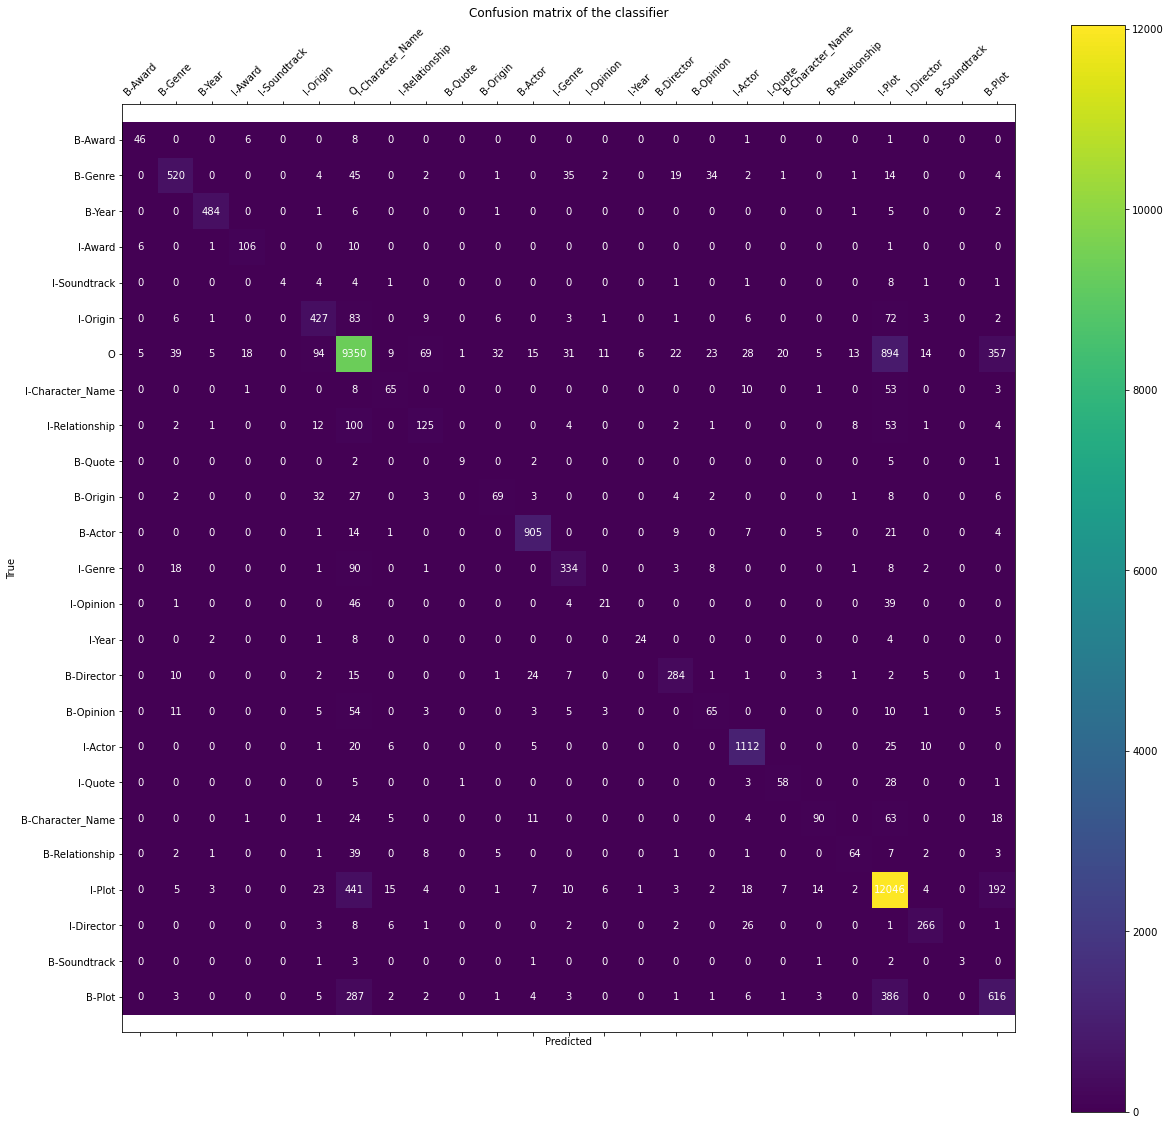

In [21]:
confusion_matrix_heatmap(y_test, preds)

In [22]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [23]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [24]:
print_transition_weights(ct._tagger.info().transitions.items())

8.523709 B-Plot   -> I-Plot
8.198099 I-Plot   -> I-Plot
7.896056 B-Actor  -> I-Actor
7.088181 I-Quote  -> I-Quote
7.080245 B-Director -> I-Director
7.018935 I-Origin -> I-Origin
6.968594 B-Origin -> I-Origin
6.789005 B-Relationship -> I-Relationship
6.744064 I-Opinion -> I-Opinion
6.712564 I-Relationship -> I-Relationship
6.622327 B-Character_Name -> I-Character_Name
6.467231 B-Opinion -> I-Opinion
6.422316 B-Quote  -> I-Quote
6.217189 B-Genre  -> I-Genre
6.065826 I-Soundtrack -> I-Soundtrack
5.903253 I-Award  -> I-Award
5.846175 B-Award  -> I-Award
5.836130 I-Genre  -> I-Genre
5.702219 I-Actor  -> I-Actor
5.507329 B-Soundtrack -> I-Soundtrack
5.063241 I-Character_Name -> I-Character_Name
4.611118 I-Director -> I-Director
4.135266 I-Year   -> I-Year
3.564666 B-Year   -> I-Year
3.412634 B-Character_Name -> B-Plot
3.333266 O        -> O
2.752797 I-Character_Name -> B-Plot
2.681774 O        -> B-Plot
2.609376 B-Plot   -> B-Character_Name
2.552154 O        -> B-Actor
2.444214 I-Actor  -> B

In [25]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [26]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

4.084558 B-Year   HAS_NUM
3.565162 I-Year   WORD_s
3.047295 B-Director SECOND_PREV_WORD_directed
2.745202 B-Year   PREF_19
2.522427 B-Character_Name PREV_WORD_named
2.352765 B-Actor  SECOND_PREV_WORD_played
2.243588 I-Plot   PREV_WORD_in
2.115123 B-Quote  PREV_WORD_line
2.107973 B-Actor  PREV_WORD_starring
2.068403 B-Character_Name PREV_WORD_character
2.060564 B-Genre  PREF_ani
2.034606 B-Soundtrack PREV_WORD_song
2.021255 B-Plot   PREV_WORD_about
2.015858 I-Soundtrack SECOND_PREV_WORD_song
2.013451 B-Award  PREF_osc
1.996866 B-Award  PREF_os
1.949581 B-Genre  WORD_animated
1.893626 B-Genre  WORD_action
1.790686 B-Actor  PREV_WORD_stars
1.786165 B-Year   PREF_20
1.780893 B-Character_Name PREV_WORD_as
1.729703 B-Plot   SECOND_PREV_WORD_about
1.709644 B-Relationship SUF_uel
1.707944 B-Genre  PREF_thr
1.596536 I-Director SECOND_PREV_WORD_director
1.546337 B-Genre  WORD_war
1.544181 B-Genre  WORD_crime
1.531886 B-Genre  WORD_musical
1.521923 I-Relationship PREV_WORD_in
1.518096 I-Genre  PR

In [27]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [28]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

C:\Users\luan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1274
         B-Award       0.73      0.71      0.72        66
B-Character_Name       0.75      0.40      0.52       283
      B-Director       0.87      0.84      0.85       425
         B-Genre       0.82      0.77      0.80       789
       B-Opinion       0.46      0.37      0.41       195
        B-Origin       0.47      0.36      0.41       190
          B-Plot       0.51      0.48      0.50      1577
         B-Quote       0.88      0.30      0.44        47
  B-Relationship       0.81      0.55      0.66       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.97      0.98      0.97       661
         I-Actor       0.91      0.94      0.92      1553
         I-Award       0.79      0.76      0.77       147
I-Character_Name       0.78      0.48      0.59       227
      I-Director       0.92      0.87      0.89       411
         I-Ge

C:\Users\luan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
